---
# <div align="center"><font color='green'> COSC 2673/2793 |  Machine Learning | Assignment 2 </font></div>
## <div align="center"> <font color='black'> Student Name: Chee Kin Go, Vincent Bethlehem </font></div>
## <div align="center"> <font color='red'> Student number: s3955624, s3899816 </font></div>
---

In [1]:
# To ensure Jupyter Notebook width size is same as your device viewport
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Problem statement

As a team of machine learning engineers at a biomedical startup, the goal is to build two separate classification model in analyzing histopathology images of colon cells:
- isCancerous Classification: Binary classification to determine whether a cell image represents cancerous cells
- Cell-Type Classification: Multi-class classification to identify cell types (fibroblast, inflammatory, epithelial, or others)

Various classification models are implemented and evaluated:
- isCancerous Classification:
    - Baseline:
    - Advanced:

- Cell-Type Classification:
     - Baseline:
     - Advanced:

By the end of evaluation, We aim to select the best-performing model for each classification method with justification

## EDA, and Data Splitting

Top 5 rows:
   InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0       22405          1  22405.png   fibroblast         0            0
1       22406          1  22406.png   fibroblast         0            0
2       22407          1  22407.png   fibroblast         0            0
3       22408          1  22408.png   fibroblast         0            0
4       22409          1  22409.png   fibroblast         0            0

Bottom 5 rows:
      InstanceID  patientID ImageName cellTypeName  cellType  isCancerous
9891        1625         60  1625.png   epithelial         2            1
9892        1626         60  1626.png   epithelial         2            1
9893        1627         60  1627.png   epithelial         2            1
9894        1628         60  1628.png   epithelial         2            1
9895        1629         60  1629.png   epithelial         2            1

Dataframe dimension:
(9896, 6)

Dataframe summary:
<class 'pandas.core.frame.DataFrame'>
RangeI

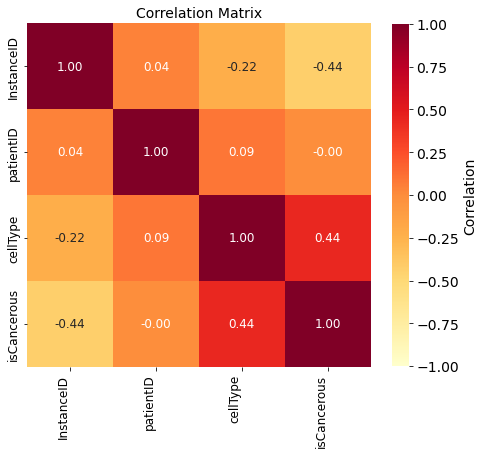

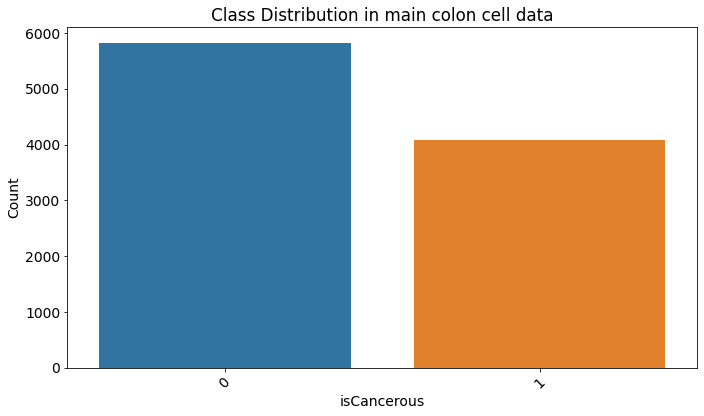


Relationship between isCancerous and other variables:


<Figure size 2160x3600 with 0 Axes>

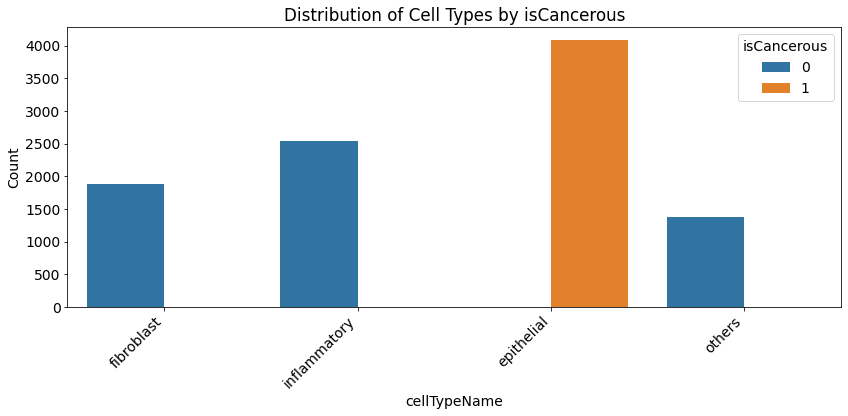

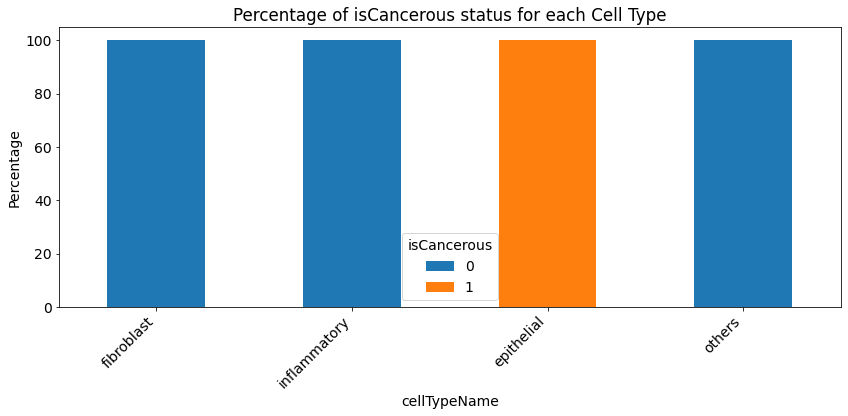

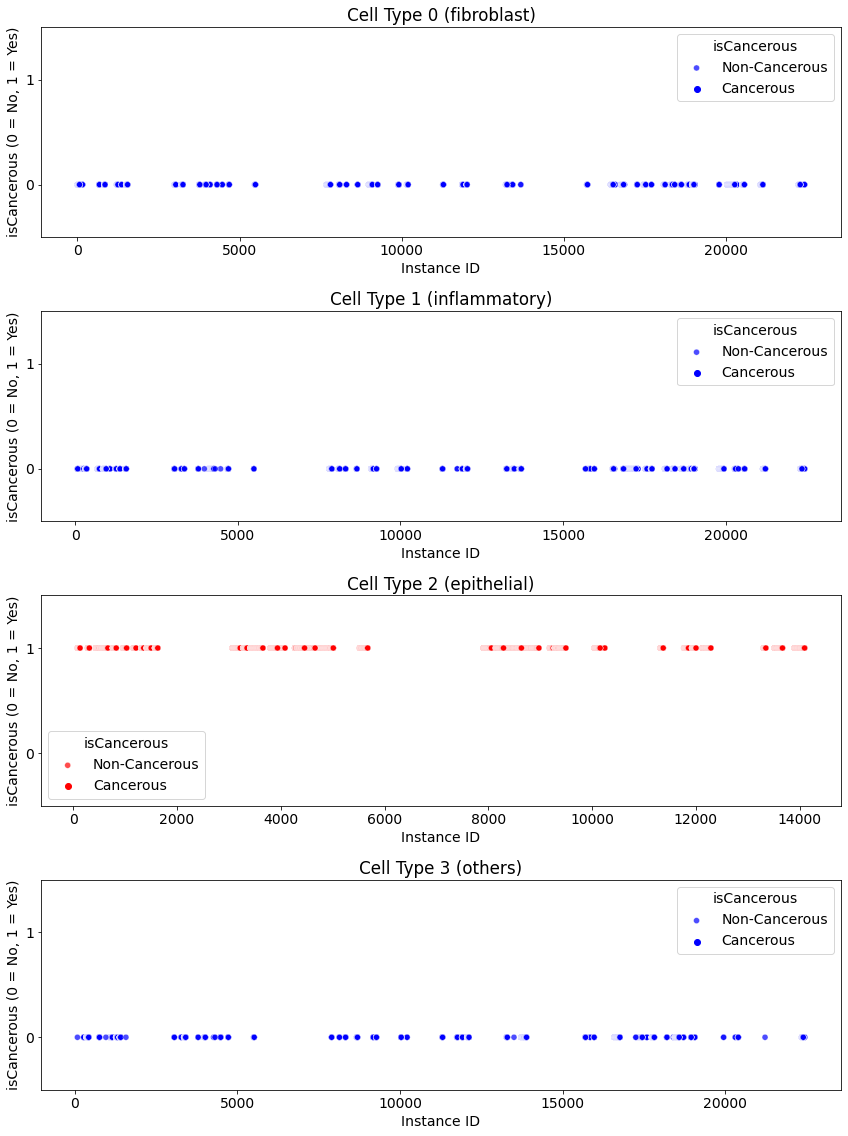

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set display options to show all columns
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Unlimited width
pd.set_option('display.expand_frame_repr', False)  # Don't wrap to multiple lines

# read csv file
mainColonCellFrame = pd.read_csv('data_labels_mainData.csv', delimiter=',')

# Print top 5 rows
print("Top 5 rows:")
print(mainColonCellFrame.head())

# Print bottom 5 rows
print("\nBottom 5 rows:")
print(mainColonCellFrame.tail())

# display dataframe dimension
print("\nDataframe dimension:")
print(mainColonCellFrame.shape)

# display dataframe summary
print("\nDataframe summary:")
print(mainColonCellFrame.info())

# check for missing value
print("\nMissing values:")
print(pd.isna(mainColonCellFrame).sum())

# check unique value for isCancerous
print("\nUnique value for isCancerous:")
print(mainColonCellFrame['isCancerous'].value_counts())

# display dataframe statistics
print("\nDataframe statistics:")
print(mainColonCellFrame.describe())

# Correlation Metrics between variables
print("\nCorrelation Metrics between variables:")
f, ax = plt.subplots(figsize=(7, 7))
corr = mainColonCellFrame.corr()

# Increase font sizes
plt.rcParams.update({'font.size': 14})  # Base font size
cbar_kws = {"shrink": 0.8, "label": "Correlation"}

# Create the heatmap with annotations and a famous color palette
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap="YlOrRd",  # Use the yellow-orange-red palette
    square=True,
    annot=True,  # This will print the values on the heatmap
    fmt=".2f",   # Format the annotations to 2 decimal places
    annot_kws={"size": 12}, 
    cbar_kws=cbar_kws
)

# Rotate x-axis labels for better readability
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right',
    fontsize=12
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize=12 
)

# Increase title font size
plt.title("Correlation Matrix", fontsize=14)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for bigger fonts
plt.show()

# class distribution
plt.figure(figsize=(10,6))
sns.countplot(data=mainColonCellFrame, x='isCancerous', order=mainColonCellFrame['isCancerous'].value_counts().index)
plt.title('Class Distribution in main colon cell data')
plt.xlabel('isCancerous')
plt.ylabel('Count')
plt.xticks(rotation=45)  # rotate if class names are long
plt.tight_layout()
plt.show()

# Relationship between isCancerous and other variables
print("\nRelationship between isCancerous and other variables:")
plt.figure(figsize=(30,50))

# Create a mapping from cellTypeName to cellType
cell_type_mapping = mainColonCellFrame[['cellTypeName', 'cellType']].drop_duplicates().set_index('cellTypeName')['cellType']

# Sort cell types by their numeric cellType value
ordered_cell_types = cell_type_mapping.sort_values().index.tolist()

# Count plot for Distribution of Cell Types by isCancerous with explicit order
plt.figure(figsize=(12, 6))
sns.countplot(data=mainColonCellFrame, x='cellTypeName', hue='isCancerous', order=ordered_cell_types)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Cell Types by isCancerous')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Stacked bar chart with the same order
bar_chart_iscancerous_by_cell_type = pd.crosstab(
    mainColonCellFrame['cellTypeName'], 
    mainColonCellFrame['isCancerous'], 
    normalize='index'
).mul(100)

# Reindex the DataFrame to match the order based on cellType numeric value
bar_chart_iscancerous_by_cell_type = bar_chart_iscancerous_by_cell_type.reindex(ordered_cell_types)

bar_chart_iscancerous_by_cell_type.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xticks(rotation=45, ha='right')
plt.title('Percentage of isCancerous status for each Cell Type')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

# Scatter plot between each cell type, PatientID and isCancerous
# Get unique cell types
mainColonCellFrame_unique_cell_types = mainColonCellFrame['cellType'].unique()

# Create a subplot for each cell type
fig, axes = plt.subplots(len(mainColonCellFrame_unique_cell_types), 1, figsize=(12, 4*len(mainColonCellFrame_unique_cell_types)))

# If there's only one cell type, axes won't be an array, so convert it to one
if len(mainColonCellFrame_unique_cell_types) == 1:
    axes = [axes]

# Create a scatter plot for each cell type
for i, cell_type in enumerate(sorted(mainColonCellFrame_unique_cell_types)):
    # Filter data for current cell type
    cell_data = mainColonCellFrame[mainColonCellFrame['cellType'] == cell_type]
    
    # Get the cell type name for the title
    cell_type_name = cell_data['cellTypeName'].iloc[0] if not cell_data.empty else f"Type {cell_type}"
    
    # Create scatter plot
    sns.scatterplot(
        data=cell_data, 
        x='InstanceID', 
        y='isCancerous',
        hue='isCancerous', 
        palette={0: 'blue', 1: 'red'}, 
        alpha=0.7,
        ax=axes[i]
    )
    
    # Set title and labels
    axes[i].set_title(f'Cell Type {cell_type} ({cell_type_name})')
    axes[i].set_xlabel('Instance ID')
    axes[i].set_ylabel('isCancerous (0 = No, 1 = Yes)')
    
    # Set y-axis to show only 0 and 1
    axes[i].set_yticks([0, 1])
    axes[i].set_ylim(-0.5, 1.5)
    
    # Add a legend
    axes[i].legend(title='isCancerous', labels=['Non-Cancerous', 'Cancerous'])

plt.tight_layout()
plt.show()

### Assignment 2

Assignment Description Here

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('data_labels_mainData.csv', delimiter=',')
pd.set_option('display.max_columns', None)

In [4]:
data.head(10)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
5,22410,1,22410.png,fibroblast,0,0
6,22411,1,22411.png,fibroblast,0,0
7,22412,1,22412.png,fibroblast,0,0
8,22413,1,22413.png,fibroblast,0,0
9,22414,1,22414.png,fibroblast,0,0
